In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2006 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_h.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m06=Minuit(twi_minus_loglikelihood_06,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m06.migrad()

pprint(m06.fval)

FCN = 3102.6479983861873 
 TOTAL NCALL = 242 
 NCALLS = 242 
 
 
 EDM = 1.1514379599162541e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.24585,0.122854,,,-3,-1,No
1,log_f_b,-3.6354,0.109046,,,-5,-2,No
2,alpha_H,3.70821,0.669108,,,1,5,No
3,poisson,1.31055,0.0423691,,,0,2,No


3102.6479983861873


In [4]:
perdata06 = pd.read_csv("perlist06_h.csv")
f_06 = perdata06['f']
per_06 = perdata06['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m06.values[0],m06.values[1],m06.values[2],m06.values[3]

model_06 = []
R_obs_06 = []
T_SSE_obs_06 = 0
f_length_06 = len(f_06)
for i in range(f_length_06):
    model_06.append(((f_06[i]**(-alpha_L))/(1+(f_06[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_06.append(2*per_06[i]/model_06[i])
    T_SSE_obs_06 += (((per_06[i]-model_06[i])/model_06[i])**2)
    
# 两个统计量
T_R_obs_06 = max(R_obs_06)
print ("T_R =", T_R_obs_06)
print ("T_SSE =", T_SSE_obs_06)

T_R = 12.982982859942226
T_SSE = 1051.0261317225973


In [5]:
# 5000条光变曲线

df = 0.01/f_length_06
N = 2*f_length_06
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_06]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_06):
        R_simu.append(2*per_simu[i]/model_06[i])
        T_SSE_simu += (((per_simu[i]-model_06[i])/model_06[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_06:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_06:
        n_TSSE += 1

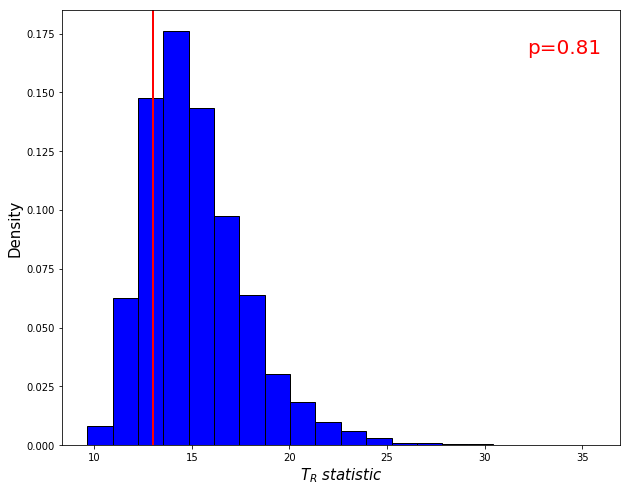

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

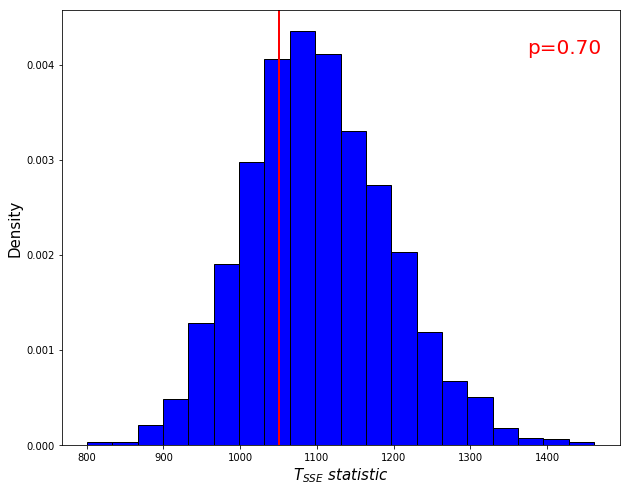

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2006 模型比较

In [8]:
def twi_minus_loglikelihood_nobreak_06(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_h.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
n06=Minuit(twi_minus_loglikelihood_nobreak_06,log_A=-9,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-11,-8),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n06.migrad()

print(n06.fval)

FCN = 3124.6182503310415 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 5.9395552553292065e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-8.00001,0.170999,,,-11,-8,No
1,alpha,2.45391,0.0182952,,,1,5,No
2,poisson,1.29697,0.0412835,,,0,2,No


3124.6182503310415


21.970251944854226


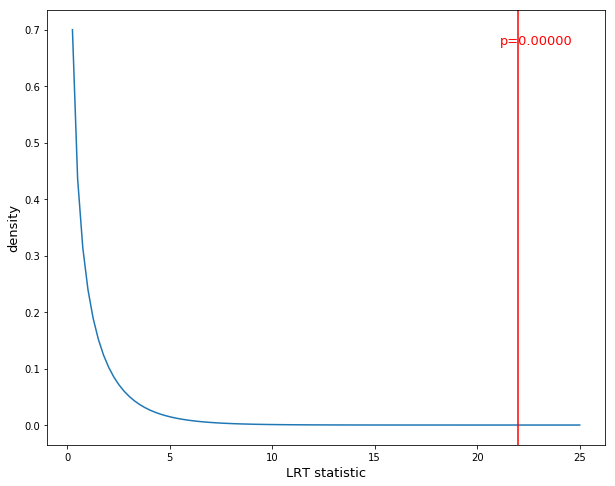

In [10]:
import scipy.stats as stats

# LRT statistic
T = n06.fval-m06.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 2009(1) 统计分析

In [11]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_h.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [12]:
m091=Minuit(twi_minus_loglikelihood_091,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,-1), limit_log_f_b=(-6,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,15),
         errordef=1)

m091.migrad()

pprint(m091.fval)

FCN = 6958.240376266562 
 TOTAL NCALL = 529 
 NCALLS = 529 
 
 
 EDM = 0.00012763921700893386 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.37182,0.65315,,,-3,-1,No
1,log_f_b,-5.03012,1.40007,,,-6,-2,No
2,alpha_H,1.72565,0.321906,,,1,5,No
3,poisson,10.984,0.409251,,,0,15,No


6958.240376266562


In [13]:
perdata091 = pd.read_csv("perlist091_h.csv")
f_091 = perdata091['f']
per_091 = perdata091['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m091.values[0],m091.values[1],m091.values[2],m091.values[3]

model_091 = []
R_obs_091 = []
T_SSE_obs_091 = 0
f_length_091 = len(f_091)
for i in range(f_length_091):
    model_091.append(((f_091[i]**(-alpha_L))/(1+(f_091[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_091.append(2*per_091[i]/model_091[i])
    T_SSE_obs_091 += (((per_091[i]-model_091[i])/model_091[i])**2)
    
# 两个统计量
T_R_obs_091 = max(R_obs_091)
print ("T_R =", T_R_obs_091)
print ("T_SSE =", T_SSE_obs_091)

T_R = 19.683415452100096
T_SSE = 1082.3585048624354


In [14]:
# 5000条光变曲线

df = 0.01/f_length_091
N = 2*f_length_091
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_091]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_091):
        R_simu.append(2*per_simu[i]/model_091[i])
        T_SSE_simu += (((per_simu[i]-model_091[i])/model_091[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_091:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_091:
        n_TSSE += 1

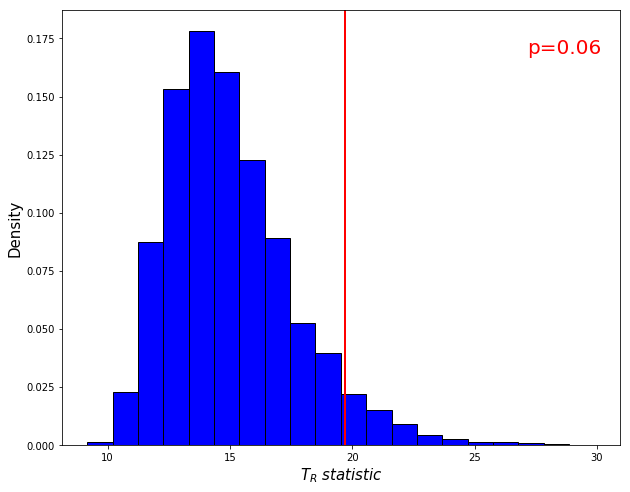

In [15]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

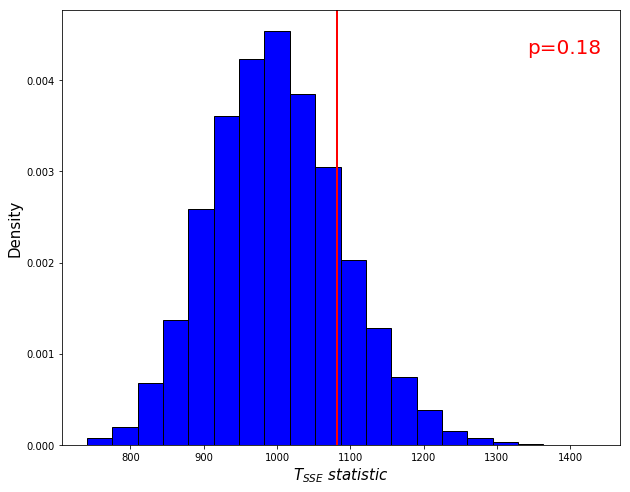

In [16]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(1) 模型比较

In [17]:
def twi_minus_loglikelihood_nobreak_091(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_h.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [18]:
n091=Minuit(twi_minus_loglikelihood_nobreak_091,log_A=-7,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-9,-6),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n091.migrad()

pprint(n091.fval)

FCN = 9423.802280796452 
 TOTAL NCALL = 123 
 NCALLS = 123 
 
 
 EDM = 3.404094388835259e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-6,0.00190236,,,-9,-6,No
1,alpha,2.93931,0.0116038,,,1,5,No
2,poisson,2,0.00189691,,,0,2,No


9423.802280796452


2465.56190452989


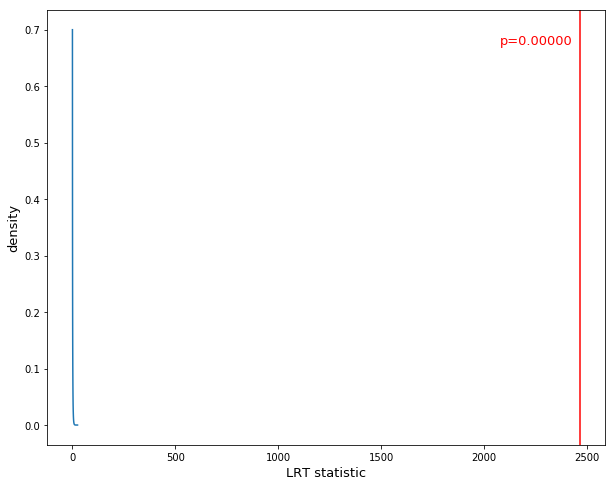

In [19]:
import scipy.stats as stats

# LRT statistic
T = n091.fval-m091.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 2009(2) 统计分析

In [20]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_h.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [21]:
m092=Minuit(twi_minus_loglikelihood_092,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,0), limit_log_f_b=(-8,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,15),
         errordef=1)

m092.migrad()

pprint(m092.fval)

FCN = 5458.92365916302 
 TOTAL NCALL = 607 
 NCALLS = 607 
 
 
 EDM = 6.651932377400898e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.00408114,2.66164,,,-3,0,No
1,log_f_b,-7.61411,3.7121,,,-8,-2,No
2,alpha_H,1.64282,0.422872,,,1,5,No
3,poisson,10.0731,0.499012,,,0,15,No


5458.92365916302


In [22]:
perdata092 = pd.read_csv("perlist092_h.csv")
f_092 = perdata092['f']
per_092 = perdata092['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m092.values[0],m092.values[1],m092.values[2],m092.values[3]

model_092 = []
R_obs_092 = []
T_SSE_obs_092 = 0
f_length_092 = len(f_092)
for i in range(f_length_092):
    model_092.append(((f_092[i]**(-alpha_L))/(1+(f_092[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_092.append(2*per_092[i]/model_092[i])
    T_SSE_obs_092 += (((per_092[i]-model_092[i])/model_092[i])**2)
    
# 两个统计量
T_R_obs_092 = max(R_obs_092)
print ("T_R =", T_R_obs_092)
print ("T_SSE =", T_SSE_obs_092)

T_R = 9.042454812932856
T_SSE = 719.4923838314827


In [23]:
# 5000条光变曲线

df = 0.01/f_length_092
N = 2*f_length_092
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_092]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_092):
        R_simu.append(2*per_simu[i]/model_092[i])
        T_SSE_simu += (((per_simu[i]-model_092[i])/model_092[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_092:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_092:
        n_TSSE += 1

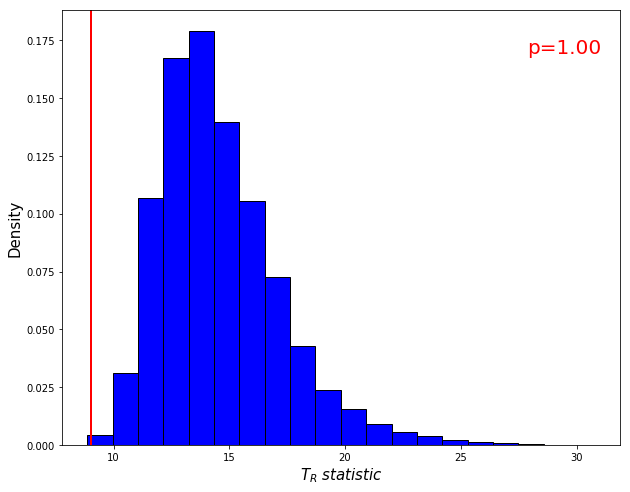

In [24]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

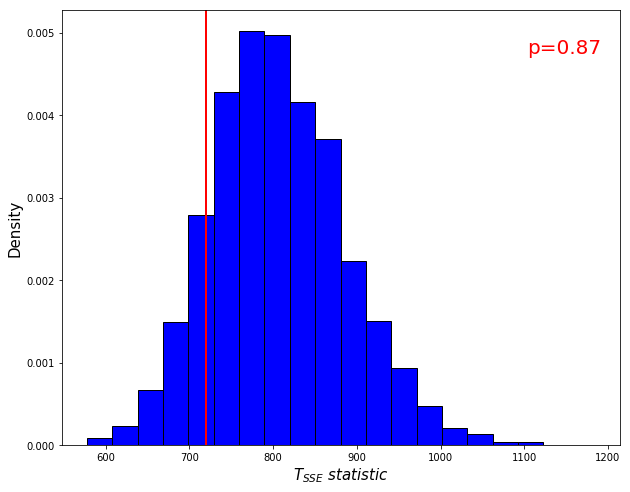

In [25]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(2) 模型比较

In [26]:
def twi_minus_loglikelihood_nobreak_092(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_h.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [27]:
n092=Minuit(twi_minus_loglikelihood_nobreak_092,log_A=-7,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-9,-6),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n092.migrad()

pprint(n092.fval)

FCN = 7242.7744575449615 
 TOTAL NCALL = 117 
 NCALLS = 117 
 
 
 EDM = 1.6952183278337442e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-6,0.00260484,,,-9,-6,No
1,alpha,2.87196,0.0139289,,,1,5,No
2,poisson,2,0.00211727,,,0,2,No


7242.7744575449615


1783.8507983819418


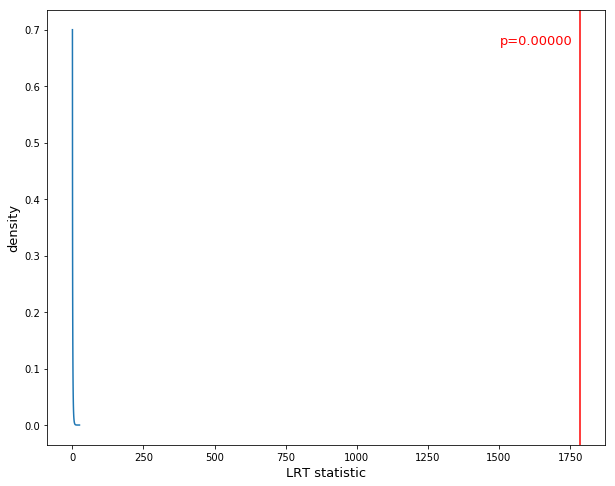

In [28]:
import scipy.stats as stats

# LRT statistic
T = n092.fval-m092.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 综合结果

In [11]:
data06 = pd.read_csv("energy_2006.csv")  
x06 = data06['x']
y06 = data06['y']
xerr06 = data06['xerr']
yerr06 = data06['yerr']

data091 = pd.read_csv("energy_2009_1.csv")  
x091 = data091['x']
y091 = data091['y']
xerr091 = data091['xerr']
yerr091 = data091['yerr']

data092 = pd.read_csv("energy_2009_2.csv")  
x092 = data092['x']
y092 = data092['y']
xerr092 = data092['xerr']
yerr092 = data092['yerr']

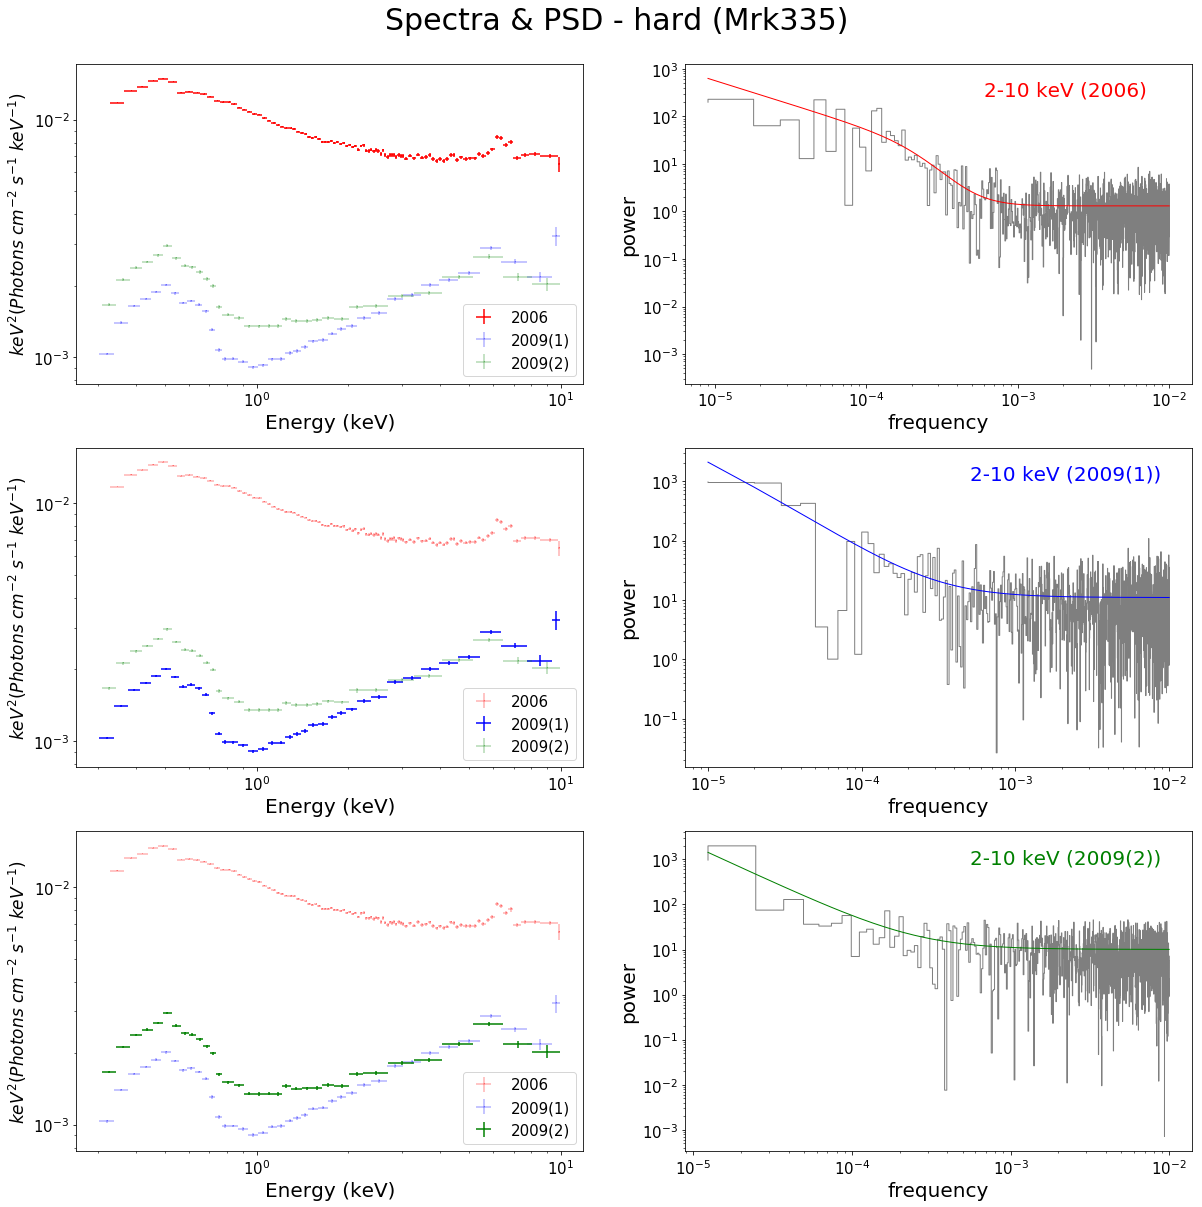

In [12]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)



ax1.loglog()
ax1.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', label='2006')
ax1.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', alpha=0.3, label='2009(1)')
ax1.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', alpha=0.3, label='2009(2)')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', alpha=0.3, label='2006')
ax3.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', label='2009(1)')
ax3.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', alpha=0.3, label='2009(2)')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', alpha=0.3, label='2006')
ax5.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', alpha=0.3, label='2009(1)')
ax5.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', label='2009(2)')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_06, per_06, color="k", alpha=0.5, linewidth=1)
ax2.plot(f_06, model_06, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2006)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_091, per_091, color="k", alpha=0.5, linewidth=1)
ax4.plot(f_091, model_091, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2009(1))",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_092, per_092, color="k", alpha=0.5, linewidth=1)
ax6.plot(f_092, model_092, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"2-10 keV (2009(2))",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)

plt.suptitle("Spectra & PSD - hard (Mrk335)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2006 MCMC

In [13]:
# 均匀先验

def lnprior_06(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < -2 and -5 < log_f_b < -3 and 2.0 < alpha_H < 6.0 and 0.0 < poisson < 2.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_06(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_06(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,poisson))

In [14]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m06.values[0],m06.values[1],m06.values[2],m06.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_06)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1393.4 seconds


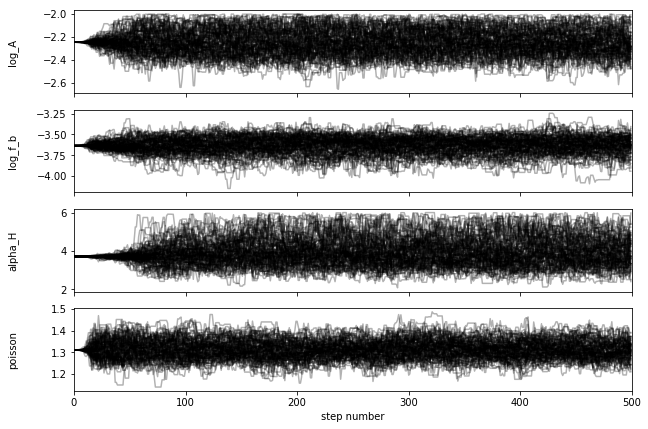

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
print ("Parameters (2006)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2006)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

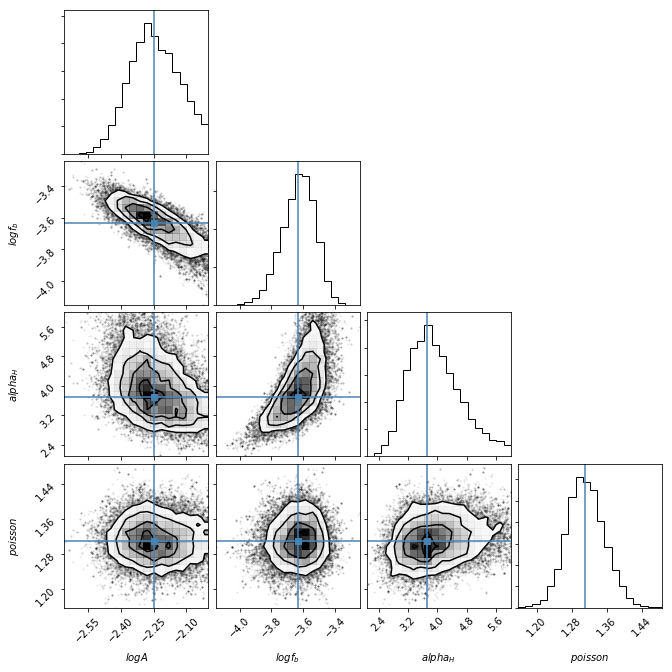

In [17]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m06.values[0], m06.values[1], m06.values[2], m06.values[3]])

## 2009(1) MCMC

In [28]:
# 均匀先验

def lnprior_091(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -10 < log_A < 10 and -25 < log_f_b < -1 and 1.0 < alpha_H < 5.0 and 5.0 < poisson < 15.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_091(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_091(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,poisson))

In [29]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m091.values[0],m091.values[1],m091.values[2],m091.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_091)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1258.8 seconds


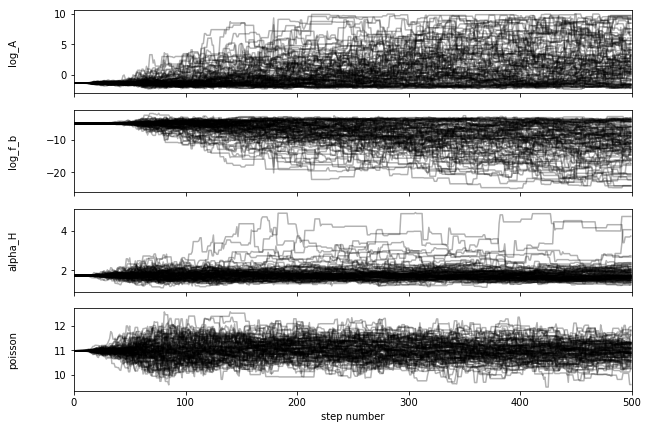

In [30]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
print ("Parameters (2009(1))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(1))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

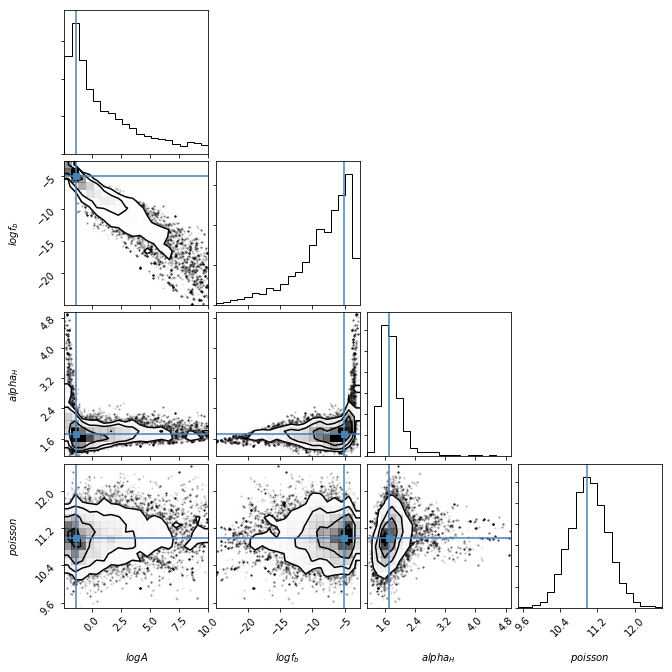

In [32]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m091.values[0], m091.values[1], m091.values[2], m091.values[3]])

## 2009(2) MCMC

In [33]:
# 均匀先验

def lnprior_092(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -10 < log_A < 20 and -35 < log_f_b < -2 and 1.0 < alpha_H < 4.0 and 5.0 < poisson < 15.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_092(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_092(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,poisson))

In [34]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m092.values[0],m092.values[1],m092.values[2],m092.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_092)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 994.1 seconds


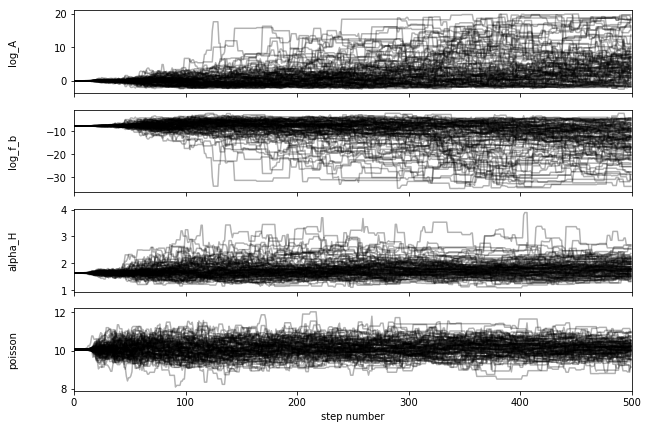

In [35]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
print ("Parameters (2009(2))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(2))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

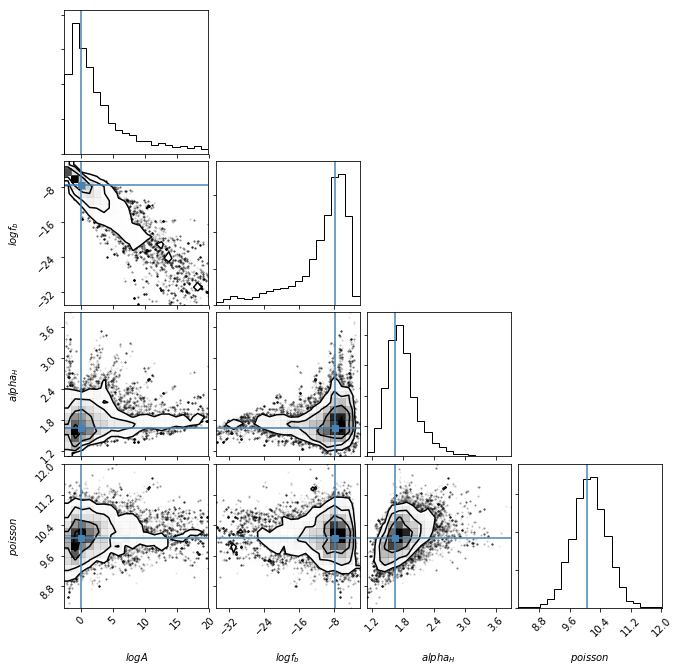

In [37]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m092.values[0], m092.values[1], m092.values[2], m092.values[3]])